<a href="https://colab.research.google.com/github/tommykil123/ObjectDetection/blob/master/ObjectDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Google Drive to Colab

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


# Unzip files from Google Drive

In [0]:
!unzip -q "/content/drive/My Drive/Colab Notebooks/ObjectDetection/images/non-vehicles.zip"
!unzip -q "/content/drive/My Drive/Colab Notebooks/ObjectDetection/images/vehicles.zip"
!unzip -q "/content/drive/My Drive/Colab Notebooks/ObjectDetection/images/object-detection-crowdai.zip"

# Pipeline

In [0]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.feature import hog  
from sklearn.preprocessing import StandardScaler
import glob

class Pipeline:
  def __init__(self):
    self.data = []
    self.car_features_hist = []
    self.notcar_features_hist = []
    self.car_features_hog = []
    self.notcar_features_hog = []
    self.car_features = []
    self.notcar_features = []
    self.car_features_norm = []
    self.notcar_features_norm = []
    
  def draw_boxes(self, img, bboxes, color=(0, 0, 255), thick=6):
    draw_img = np.copy(img)
    for bbox in bboxes:
        cv2.rectangle(draw_img, bbox[0], bbox[1], color, thick)
    return draw_img
  
  def find_matches_basic(self, img, template_list):
    bbox_list = []
    # Define matching method   
    method = cv2.TM_CCOEFF_NORMED  # Other options include: cv2.TM_CCORR_NORMED', 'cv2.TM_CCOEFF', 'cv2.TM_CCORR', 'cv2.TM_SQDIFF', 'cv2.TM_SQDIFF_NORMED'
    for temp in template_list:
        tmp = mpimg.imread(temp)
        result = cv2.matchTemplate(img, tmp, method)
        # Use cv2.minMaxLoc() to extract the location of the best match
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)
        # Determine a bounding box for the match
        w, h = (tmp.shape[1], tmp.shape[0])
        if method in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED]:
            top_left = min_loc
        else:
            top_left = max_loc
        bottom_right = (top_left[0] + w, top_left[1] + h)
        # Append bbox position to list
        bbox_list.append((top_left, bottom_right))
        # Return the list of bounding boxes        
    return bbox_list
  
  # Define a function to compute color histogram features  
  def color_hist(self, img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the RGB channels separately
    rhist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    ghist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    bhist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Generating bin centers
    bin_edges = rhist[1] # rhist is two array (0: Height, 1: Edges)
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return rhist, ghist, bhist, bin_centers, hist_features
  
  def bin_spatial_solo(self, img, color_space='RGB', size=(32, 32)):
    # Convert image to new color space (if specified)
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)             
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(feature_image, size).ravel() 
    # Return the feature vector
    return features
  
  # Define a function to return some characteristics of the dataset 
  def data_look(self, car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    example_img = mpimg.imread(car_list[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = example_img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = example_img.dtype
    # Return data_dict
    return data_dict
  
  def get_hog_features_solo(self, img, orient, pix_per_cell, cell_per_block, vis=True,
                     feature_vec=True):                
    """
    Function accepts params and returns HOG features (optionally flattened) and an optional matrix for 
    visualization. Features will always be the first return (flattened if feature_vector= True).
    A visualization matrix will be the second return if visualize = True.
    """
    return_list = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  block_norm= 'L2-Hys', transform_sqrt=False, 
                                  visualize= vis, feature_vector= feature_vec)
    # name returns explicitly
    hog_features = return_list[0]
    if vis:
        hog_image = return_list[1]
        return hog_features, hog_image
    else:
        return hog_features
      
  # Define a function to compute binned color features  
  def bin_spatial(self, img, size=(32, 32)):
      # Use cv2.resize().ravel() to create the feature vector
      features = cv2.resize(img, size).ravel() 
      # Return the feature vector
      return features

  # Define a function to compute color histogram features  
  def color_hist(self, img, nbins=32, bins_range=(0, 256)):
      # Compute the histogram of the color channels separately
      channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
      channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
      channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
      # Concatenate the histograms into a single feature vector
      hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
      # Return the individual histograms, bin_centers and feature vector
      return hist_features
  
  # Define a function to extract features from a list of images
  # Have this function call bin_spatial() and color_hist()
  def extract_features_hist(self, imgs, cspace='RGB', spatial_size=(32, 32),
                          hist_bins=32, hist_range=(0, 256)):
      # Create a list to append feature vectors to
      features = []
      # Iterate through the list of images
      for file in imgs:
          # Read in each one by one
          image = mpimg.imread(file)
          # apply color conversion if other than 'RGB'
          if cspace != 'RGB':
              if cspace == 'HSV':
                  feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
              elif cspace == 'LUV':
                  feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
              elif cspace == 'HLS':
                  feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
              elif cspace == 'YUV':
                  feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
          else: feature_image = np.copy(image)      
          # Apply bin_spatial() to get spatial color features
          spatial_features = self.bin_spatial(feature_image, size=spatial_size)
          # Apply color_hist() also with a color space option now
          hist_features = self.color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
          # Append the new feature vector to the features list
          features.append(np.concatenate((spatial_features, hist_features)))
      # Return list of feature vectors
      return features  
    
  # Define a function to return HOG features and visualization
  def get_hog_features(self, img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), block_norm= 'L2-Hys',
                                  transform_sqrt=True, 
                                  visualize=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), block_norm= 'L2-Hys',
                       transform_sqrt=True, 
                       visualize=vis, feature_vector=feature_vec)
        return features  
      
  # Define a function to extract features from a list of images
  # Have this function call bin_spatial() and color_hist()
  def extract_features_hog(self, imgs, cspace='RGB', orient=9, 
                          pix_per_cell=8, cell_per_block=2, hog_channel=0):
      # Create a list to append feature vectors to
      features = []
      # Iterate through the list of images
      for file in imgs:
          # Read in each one by one
          image = mpimg.imread(file)
          # apply color conversion if other than 'RGB'
          if cspace != 'RGB':
              if cspace == 'HSV':
                  feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
              elif cspace == 'LUV':
                  feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
              elif cspace == 'HLS':
                  feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
              elif cspace == 'YUV':
                  feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
              elif cspace == 'YCrCb':
                  feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
          else: feature_image = np.copy(image)      

          # Call get_hog_features() with vis=False, feature_vec=True
          if hog_channel == 'ALL':
              hog_features = []
              for channel in range(feature_image.shape[2]):
                  hog_features.append(self.get_hog_features(feature_image[:,:,channel], 
                                      orient, pix_per_cell, cell_per_block, 
                                      vis=False, feature_vec=True))
              hog_features = np.ravel(hog_features)        
          else:
              hog_features = self.get_hog_features(feature_image[:,:,hog_channel], orient, 
                          pix_per_cell, cell_per_block, vis=False, feature_vec=True)
          # Append the new feature vector to the features list
          features.append(hog_features)
      # Return list of feature vectors
      return features
    
  def extract_features(self, imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = self.bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = self.color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(self.get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = self.get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features
  
    
  # Define a function that takes an image, start and stop positions in both x and y, 
  # window size (x and y dimensions), and overlap fraction (for both x and y)
  def slide_window(self, img, x_start_stop=[None, None], y_start_stop=[None, None], 
                      xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
      # If x and/or y start/stop positions not defined, set to image size
      if x_start_stop[0] == None:
          x_start_stop[0] = 0
      if x_start_stop[1] == None:
          x_start_stop[1] = img.shape[1]
      if y_start_stop[0] == None:
          y_start_stop[0] = 0
      if y_start_stop[1] == None:
          y_start_stop[1] = img.shape[0]
      # Compute the span of the region to be searched    
      xspan = x_start_stop[1] - x_start_stop[0]
      yspan = y_start_stop[1] - y_start_stop[0]
      # Compute the number of pixels per step in x/y
      nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
      ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
      # Compute the number of windows in x/y
      nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
      ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
      nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
      ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
      # Initialize a list to append window positions to
      window_list = []
      # Loop through finding x and y window positions
      # Note: you could vectorize this step, but in practice
      # you'll be considering windows one by one with your
      # classifier, so looping makes sense
      for ys in range(ny_windows):
          for xs in range(nx_windows):
              # Calculate window position
              startx = xs*nx_pix_per_step + x_start_stop[0]
              endx = startx + xy_window[0]
              starty = ys*ny_pix_per_step + y_start_stop[0]
              endy = starty + xy_window[1]

              # Append window position to list
              window_list.append(((startx, starty), (endx, endy)))
      # Return the list of windows
      return window_list

  # Define a function to draw bounding boxes
  def draw_boxes(self, img, bboxes, color=(0, 0, 255), thick=6):
      # Make a copy of the image
      imcopy = np.copy(img)
      # Iterate through the bounding boxes
      for bbox in bboxes:
          # Draw a rectangle given bbox coordinates
          cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
      # Return the image copy with boxes drawn
      return imcopy

  # Define a function to extract features from a single image window
  # This function is very similar to extract_features() just for a single image rather than list of images
  def single_img_features(self, img, color_space='RGB', spatial_size=(32, 32),
                          hist_bins=32, orient=9, 
                          pix_per_cell=8, cell_per_block=2, hog_channel=0,
                          spatial_feat=True, hist_feat=True, hog_feat=True):    
      #1) Define an empty list to receive features
      img_features = []
      #2) Apply color conversion if other than 'RGB'
      if color_space != 'RGB':
          if color_space == 'HSV':
              feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
          elif color_space == 'LUV':
              feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
          elif color_space == 'HLS':
              feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
          elif color_space == 'YUV':
              feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
          elif color_space == 'YCrCb':
              feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
      else: feature_image = np.copy(img)      
      #3) Compute spatial features if flag is set
      if spatial_feat == True:
          spatial_features = self.bin_spatial(feature_image, size=spatial_size)
          #4) Append features to list
          img_features.append(spatial_features)
      #5) Compute histogram features if flag is set
      if hist_feat == True:
          hist_features = self.color_hist(feature_image, nbins=hist_bins)
          #6) Append features to list
          img_features.append(hist_features)
      #7) Compute HOG features if flag is set
      if hog_feat == True:
          if hog_channel == 'ALL':
              hog_features = []
              for channel in range(feature_image.shape[2]):
                  hog_features.extend(self.get_hog_features(feature_image[:,:,channel], 
                                      orient, pix_per_cell, cell_per_block, 
                                      vis=False, feature_vec=True))      
          else:
              hog_features = self.get_hog_features(feature_image[:,:,hog_channel], orient, 
                          pix_per_cell, cell_per_block, vis=False, feature_vec=True)
          #8) Append features to list
          img_features.append(hog_features)

      #9) Return concatenated array of features
      return np.concatenate(img_features)

  # Define a function you will pass an image 
  # and the list of windows to be searched (output of slide_windows())
  def search_windows(self, img, windows, clf, scaler, color_space='RGB', 
                      spatial_size=(32, 32), hist_bins=32, 
                      hist_range=(0, 256), orient=9, 
                      pix_per_cell=8, cell_per_block=2, 
                      hog_channel=0, spatial_feat=True, 
                      hist_feat=True, hog_feat=True):

      #1) Create an empty list to receive positive detection windows
      on_windows = []
      #2) Iterate over all windows in the list
      for window in windows:
          #3) Extract the test window from original image
          test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
          #4) Extract features for that window using single_img_features()
          features = self.single_img_features(test_img, color_space=color_space, 
                              spatial_size=spatial_size, hist_bins=hist_bins, 
                              orient=orient, pix_per_cell=pix_per_cell, 
                              cell_per_block=cell_per_block, 
                              hog_channel=hog_channel, spatial_feat=spatial_feat, 
                              hist_feat=hist_feat, hog_feat=hog_feat)
          #5) Scale extracted features to be fed to classifier
          test_features = scaler.transform(np.array(features).reshape(1, -1))
          #6) Predict using your classifier
          prediction = clf.predict(test_features)
          #7) If positive (prediction == 1) then save the window
          if prediction == 1:
              on_windows.append(window)
      #8) Return windows for positive detections
      return on_windows
  
  def convert_color(self, img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
      
  # Define a single function that can extract features using hog sub-sampling and make predictions
  def find_cars(self, img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
      draw_img = np.copy(img)
      img = img.astype(np.float32)/255

      img_tosearch = img[ystart:ystop,:,:]
      ctrans_tosearch = self.convert_color(img_tosearch, conv='RGB2YCrCb')
      if scale != 1:
          imshape = ctrans_tosearch.shape
          ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

      ch1 = ctrans_tosearch[:,:,0]
      ch2 = ctrans_tosearch[:,:,1]
      ch3 = ctrans_tosearch[:,:,2]

      # Define blocks and steps as above
      nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
      nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
      nfeat_per_block = orient*cell_per_block**2

      # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
      window = 64
      nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
      cells_per_step = 2  # Instead of overlap, define how many cells to step
      nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
      nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1

      # Compute individual channel HOG features for the entire image
      hog1 = self.get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
      hog2 = self.get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
      hog3 = self.get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

      for xb in range(nxsteps):
          for yb in range(nysteps):
              ypos = yb*cells_per_step
              xpos = xb*cells_per_step
              # Extract HOG for this patch
              hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
              hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
              hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
              hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

              xleft = xpos*pix_per_cell
              ytop = ypos*pix_per_cell

              # Extract the image patch
              subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))

              # Get color features
              spatial_features = self.bin_spatial(subimg, size=spatial_size)
              hist_features = self.color_hist(subimg, nbins=hist_bins)
              # Scale features and make a prediction
              print(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))
              test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
              #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
              test_prediction = svc.predict(test_features)
              if test_prediction == 1:
                  xbox_left = np.int(xleft*scale)
                  ytop_draw = np.int(ytop*scale)
                  win_draw = np.int(window*scale)
                  cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 

      return draw_img

pipeline = Pipeline()

#Extract Data

In [0]:
base_path = '/content/drive/My Drive/Colab Notebooks/ObjectDetection/images/'

car_images = glob.glob('/content/vehicles/*/*.png')
not_car_images = glob.glob('/content/non-vehicles/*/*.png')
cars = []
notcars = []

for image in car_images:
  cars.append(image)
for image in not_car_images:
  notcars.append(image)

#  Manually Detect Vehicle

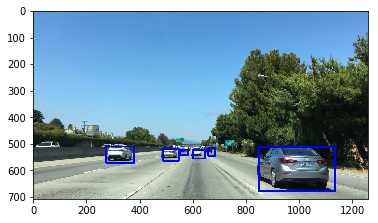

In [0]:
image = mpimg.imread('/content/drive/My Drive/Colab Notebooks/ObjectDetection/images/sample_images/bbox-example-image.jpg')
bboxes = [((275, 572), (380, 510)), ((488, 563), (549, 518)), ((554, 543), (582, 522)), 
          ((601, 555), (646, 522)), ((657, 545), (685, 517)), ((849, 678), (1135, 512))]

result = pipeline.draw_boxes(image, bboxes)
plt.imshow(result)


# Template Matching

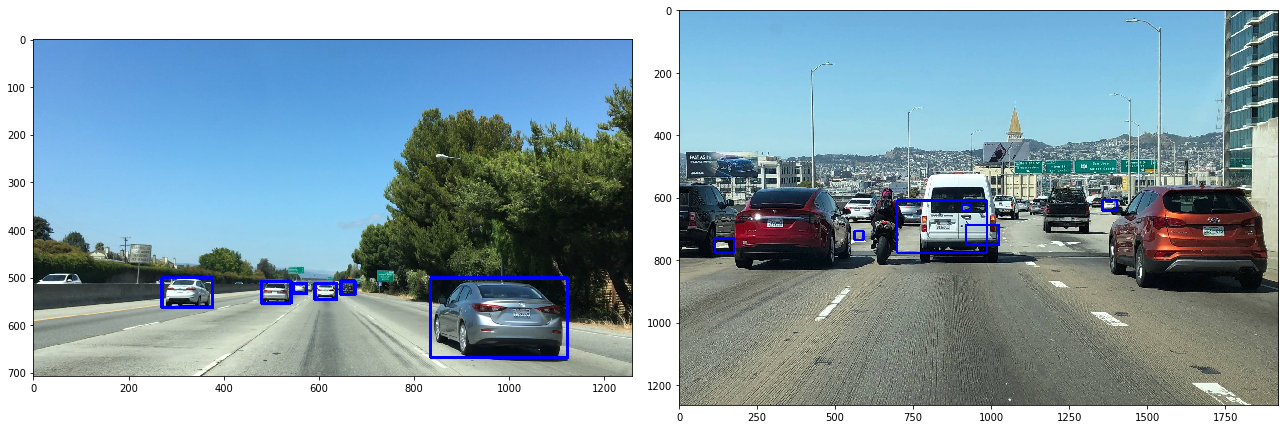

In [0]:
image = mpimg.imread(base_path + 'sample_images/bbox-example-image.jpg')
image2 = mpimg.imread(base_path + 'sample_images/VehicleOnRoadGoogle.jpg')
templist = [base_path + 'cutouts/' + 'cutout1.jpg', base_path + 'cutouts/' + 'cutout2.jpg', base_path + 'cutouts/' + 'cutout3.jpg',
            base_path + 'cutouts/' + 'cutout4.jpg', base_path + 'cutouts/' + 'cutout5.jpg', base_path + 'cutouts/' + 'cutout6.jpg']

fig = plt.figure(figsize=(18,12))
plt.subplot(121)
bboxes = pipeline.find_matches_basic(image, templist)
result = pipeline.draw_boxes(image, bboxes)
plt.imshow(result)
plt.subplot(122)
bboxes2 = pipeline.find_matches_basic(image2, templist)
result2 = pipeline.draw_boxes(image2, bboxes2)
plt.imshow(result2)
fig.tight_layout()

# Histogram of Colors in RGB

Feature Vector is: [400 441 302 244 189 283 412 433 239 177 209 302 276 179 129 106 104 111
 106  96 111 123 139 130 167 164 149 156 222 268 258  53  95 219 441 331
 235 179 188 324 340 321 252 215 242 296 244 198 133 117  98 127  88 120
 104  88 117 172 152 142 133 159 219 589 106 206 367 337 230 174 235 328
 316 238 189 227 261 271 291 244 179 148 134 112 129 123  94  93 160 138
 117 110 121 148 219 633]


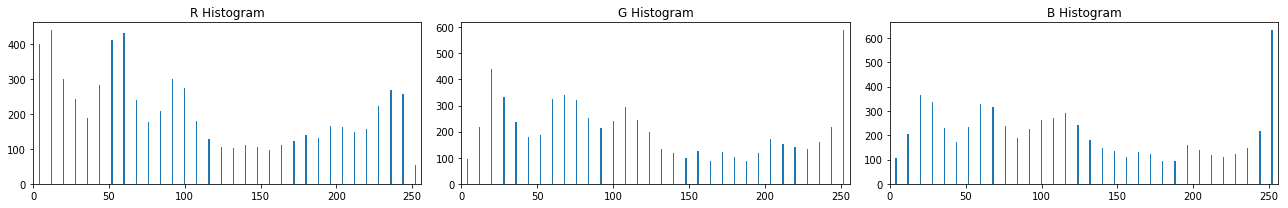

In [0]:
image = mpimg.imread(base_path + 'cutouts/' + 'cutout1.jpg')
    
rh, gh, bh, bincen, feature_vec = pipeline.color_hist(image, nbins=32, bins_range=(0, 256))
# Plot a figure with all three bar charts
if rh is not None:
    fig = plt.figure(figsize=(18,3))
    plt.subplot(131)
    plt.bar(bincen, rh[0])
    plt.xlim(0, 256)
    plt.title('R Histogram')
    plt.subplot(132)
    plt.bar(bincen, gh[0])
    plt.xlim(0, 256)
    plt.title('G Histogram')
    plt.subplot(133)
    plt.bar(bincen, bh[0])
    plt.xlim(0, 256)
    plt.title('B Histogram')
    fig.tight_layout()
else:
    print('Your function is returning None for at least one variable...')

print('Feature Vector is: ' + str(feature_vec))

# Spatial Binning of Colors

Feature Vector is: [122 138 137 ... 139 152 141]


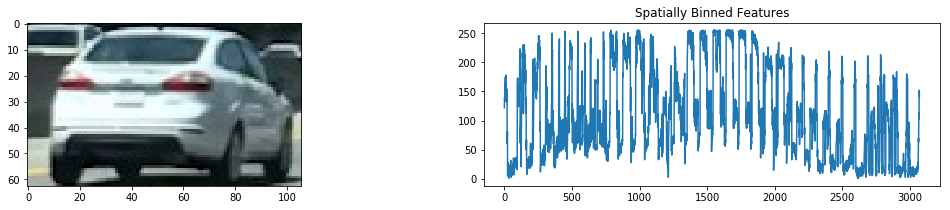

In [0]:
image = mpimg.imread(base_path + 'cutouts/' + 'cutout1.jpg')
  
feature_vec = pipeline.bin_spatial_solo(image, color_space='RGB', size=(32, 32))
# Plot features
fig = plt.figure(figsize=(18,3))
plt.subplot(1,2,1)
plt.imshow(image)
plt.subplot(1,2,2)
plt.plot(feature_vec)
plt.title('Spatially Binned Features')

print('Feature Vector is: ' + str(feature_vec))

# Explore the Data

Your function returned a count of 8792  cars and 8968  non-cars
of size:  (64, 64, 3)  and data type: float32


Text(0.5, 1.0, 'Example Not-car Image')

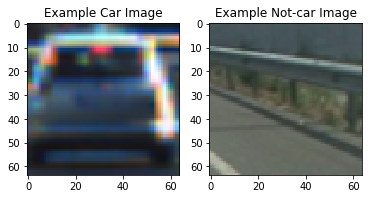

In [0]:
#from skimage.feature import hog
#from skimage import color, exposure
    
data_info = pipeline.data_look(cars, notcars)
print('Your function returned a count of', 
      data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])
# Just for fun choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
    
# Read in car / not-car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])

# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Image')


# HOG Visualization

Text(0.5, 1.0, 'HOG Visualization')

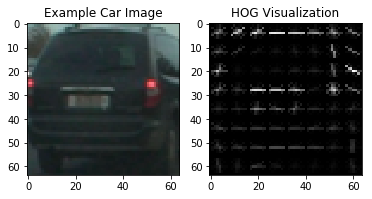

In [0]:
# Generate a random index to look at a car image
ind = np.random.randint(0, len(car_images))
# Read in the image
image = mpimg.imread(car_images[ind])
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# Call our function with vis=True to see an image output
features, hog_image = pipeline.get_hog_features_solo(gray, orient= 9, 
                        pix_per_cell= 8, cell_per_block= 2, 
                        vis=True, feature_vec=False)

# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(image, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')

# Combine and Normalize Features

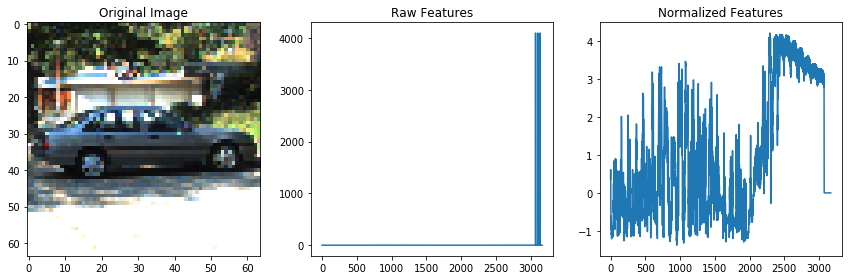

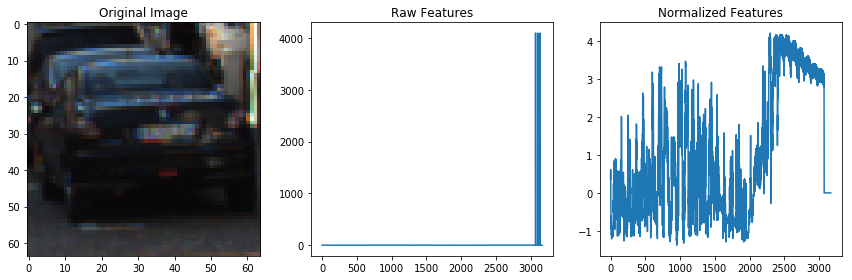

In [0]:
pipeline.car_features_hist = pipeline.extract_features_hist(cars, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256))
pipeline.notcar_features_hist = pipeline.extract_features_hist(notcars, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256))

if len(car_features) > 0:
    # Create an array stack of feature vectors
    X = np.vstack((pipeline.car_features_hist, pipeline.notcar_features_hist)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    car_ind = np.random.randint(0, len(cars))
    # Plot an example of raw and scaled features
    fig = plt.figure(figsize=(12,4))
    plt.subplot(131)
    plt.imshow(mpimg.imread(cars[car_ind]))
    plt.title('Original Image')
    plt.subplot(132)
    plt.plot(X[car_ind])
    plt.title('Raw Features')
    plt.subplot(133)
    plt.plot(scaled_X[car_ind])
    plt.title('Normalized Features')
    fig.tight_layout()
    # Plot an example of raw and scaled features
    fig = plt.figure(figsize=(12,4))
    plt.subplot(131)
    plt.imshow(mpimg.imread(cars[car_ind+1]))
    plt.title('Original Image')
    plt.subplot(132)
    plt.plot(X[car_ind])
    plt.title('Raw Features')
    plt.subplot(133)
    plt.plot(scaled_X[car_ind])
    plt.title('Normalized Features')
    fig.tight_layout()
else: 
    print('Your function only returns empty feature vectors...')

#Color Classify

In [0]:
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import time
# TODO play with these values to see how your classifier
# performs under different binning scenarios
spatial = 32
histbin = 32

pipeline.car_features_hist = pipeline.extract_features_hist(cars, cspace='RGB', spatial_size=(spatial, spatial),
                        hist_bins=histbin, hist_range=(0, 256))
pipeline.notcar_features_hist = pipeline.extract_features_hist(notcars, cspace='RGB', spatial_size=(spatial, spatial),
                        hist_bins=histbin, hist_range=(0, 256))

# Create an array stack of feature vectors
X = np.vstack((pipeline.car_features_hist, pipeline.notcar_features_hist)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(pipeline.car_features_hist)), np.zeros(len(pipeline.notcar_features_hist))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)
    
# Fit a per-column scaler only on the training data
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X_train and X_test
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

print('Using spatial binning of:',spatial,
    'and', histbin,'histogram bins')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Using spatial binning of: 32 and 32 histogram bins
Feature vector length: 3168
100.12 Seconds to train SVC...
Test Accuracy of SVC =  0.9181
My SVC predicts:  [0. 0. 0. 1. 1. 1. 0. 0. 0. 1.]
For these 10 labels:  [0. 0. 0. 1. 1. 1. 0. 0. 0. 1.]
0.0032 Seconds to predict 10 labels with SVC


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


#HOG Classify

In [0]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split
#from sklearn.cross_validation import train_test_split


### TODO: Tweak these parameters and see how the results change.
colorspace = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 0 # Can be 0, 1, 2, or "ALL"

t=time.time()
pipeline.car_features_hog = pipeline.extract_features_hog(cars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
pipeline.notcar_features_hog = pipeline.extract_features_hog(notcars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')

# Create an array stack of feature vectors
X = np.vstack((pipeline.car_features_hog, pipeline.notcar_features_hog)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(pipeline.car_features_hog)), np.zeros(len(pipeline.notcar_features_hog))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)
    
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')  

/usr/local/lib/python3.6/dist-packages/skimage/feature/_hog.py:239: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)


37.21 Seconds to extract HOG features...
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 1764
20.74 Seconds to train SVC...
Test Accuracy of SVC =  0.9493
My SVC predicts:  [0. 1. 0. 1. 0. 1. 0. 1. 0. 0.]
For these 10 labels:  [1. 1. 0. 1. 0. 1. 0. 1. 0. 0.]
0.00209 Seconds to predict 10 labels with SVC


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


#Sliding Window

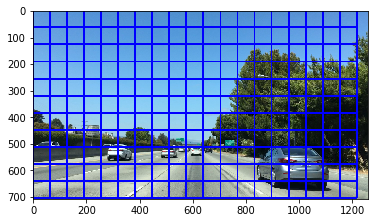

In [0]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

image = mpimg.imread('/content/drive/My Drive/Colab Notebooks/ObjectDetection/images/sample_images/bbox-example-image.jpg')

# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy
    
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(128, 128), xy_overlap=(0.5, 0.5))
                       
window_img = draw_boxes(image, windows, color=(0, 0, 255), thick=6)                    
plt.imshow(window_img)

#Search and Classify

In [0]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split
#from sklearn.cross_validation import train_test_split  

### TODO: Tweak these parameters and see how the results change.
color_space = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 0 # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [500, 700] # Min and max in y to search in slide_window()

pipeline.car_features = pipeline.extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
pipeline.notcar_features = pipeline.extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

# Create an array stack of feature vectors
X = np.vstack((pipeline.car_features, pipeline.notcar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(pipeline.car_features)), np.zeros(len(pipeline.notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)
    
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

image = mpimg.imread('/content/drive/My Drive/Colab Notebooks/ObjectDetection/images/sample_images/bbox-example-image.jpg')
draw_image = np.copy(image)

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
#image = image.astype(np.float32)/255

windows = pipeline.slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(96, 96), xy_overlap=(0.5, 0.5))

hot_windows = pipeline.search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

window_img = pipeline.draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

plt.imshow(window_img)




KeyboardInterrupt: ignored

# Hog Sub Sampling Window Search

In [0]:
ystart = 400
ystop = 656
scale = 1.5
spatial_size = (32,32)
image = mpimg.imread('/content/drive/My Drive/Colab Notebooks/ObjectDetection/images/sample_images/bbox-example-image.jpg')    
out_img = pipeline.find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
plt.imshow(out_img)
#3072, 96, 5292

[[0.14872953 0.4831239  0.50476319 ... 0.23324486 0.12279795 0.01512154]]


ValueError: ignored

In [0]:
print(X_scaler.mean_)

[0.33697573 0.34881468 0.32250383 ... 0.07561602 0.05908205 0.06267465]
